## Libraries and Modules

In [34]:
from numpy import zeros
from numpy import ones
import os
import cv2
import numpy as np
import pandas as pd
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils import to_categorical


from matplotlib import pyplot as plt

## Load Images
 black_Shirts, blue_Shirts, green_Shirts, and red_Shirts which contain the paths to different directories in a dataset. These directories are related to colored shirts.

In [35]:
trainX = []
trainy = []

black_Shirts = "Clothes Coloured Dataset/black_shirt"
blue_Shirts = "Clothes Coloured Dataset/blue_shirt"
green_Shirts = "Clothes Coloured Dataset/green_shirt"
red_Shirts = "Clothes Coloured Dataset/red_shirt"


In [36]:
black_img = os.listdir(black_Shirts)
blue_img = os.listdir(blue_Shirts)
green_img = os.listdir(blue_Shirts)
red_img = os.listdir(red_Shirts)

In [37]:
len(black_img)

715

In [38]:
len(blue_img)

741

In [39]:
len(green_img)

741

In [40]:
len(red_img)

332

## Associate Images with their corresponding labels

In [41]:
def images_class_association(folder, num):
    for image in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, image))
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
        img = np.array(img)
        trainX.append(img)
        trainy.append(num)

In [42]:
images_class_association(black_Shirts, 0)
images_class_association(blue_Shirts, 1)
images_class_association(green_Shirts, 2)
images_class_association(red_Shirts, 3)

In [43]:
def show_Image(index):
    plt.imshow(trainX[index])
    plt.show()
    print(trainy[index])


## Random Analysis

In [44]:
trainX = np.array(trainX)
trainy = np.array(trainy)

In [45]:
type(trainy)

numpy.ndarray

In [46]:
print(trainX.shape)
print(trainy.shape)

(2018, 32, 32, 3)
(2018,)


In [47]:
trainy = np.reshape(trainy, (2018, 1))

print(trainy.shape)

(2018, 1)


In [48]:
print(len(trainX))
print(len(trainy))

2018
2018


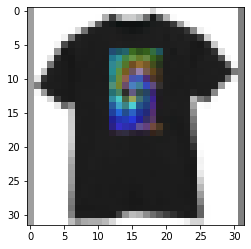

[0]


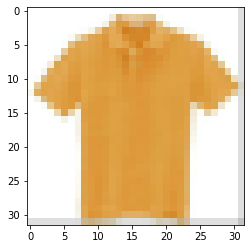

[1]


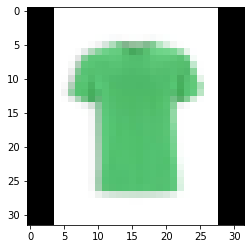

[2]


In [54]:
show_Image(124)
show_Image(1234)
show_Image(1670)

## Split Data to train and test 
20% of the data will be used for testing, and 80% will be used for training.

In [31]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(trainX, trainy, test_size = 0.2)

In [32]:
print("Train X = ", trainX.shape)
print("Train Y = ", trainY.shape)
print("Test X = ", testX.shape)
print("Test Y = ", testY.shape)

Train X =  (1614, 32, 32, 3)
Train Y =  (1614, 1)
Test X =  (404, 32, 32, 3)
Test Y =  (404, 1)


In [33]:
print(testY[300])

[0]


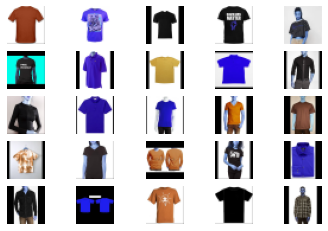

In [34]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

## Discriminator Model
Responsible for distinguishing between real and fake samples.

In [39]:
def define_discriminator(in_shape=(32,32,3)): # inputs are of size (32, 32, 3)   
	model = Sequential() #  becuase it is one layer after the another.
	 
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1 and sigmoid because it is a simple binary classifier.
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [40]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                

## Generater Model
Generator is responsible for generating new samples from random noise.

In [73]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g, 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsampling or upscaling to 16x16
	model.add(Conv2DTranspose(128, (4,4) , strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
    
#     	# upsample to 64x64
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
# 	model.add(LeakyReLU(alpha=0.2))
    
#     	# upsample to 128x128
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
# 	model.add(LeakyReLU(alpha=0.2))
    
#     	# upsample to 256x256
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
# 	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #last layer is designed in such 
                                                                    #away that we get an output of 32x32x3
    
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

In [74]:
test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                           

# GAN Model
GAN (Generative Adversarial Network) model by combining the generator and discriminator models. In GANs, the generator generates new samples, and the discriminator tries to distinguish between real and fake samples.

Define the generator and discrimniator model for updating the generator, 
As descriminator is trained successfully so here only generator will be trained by keepind the descrminator constant

In [43]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  # Discriminator is trained separately. So set to not trainable.

    # connect generator and discriminator
	model = Sequential()
	model.add(generator) # so it will add all the gernerator and discriminator layers except discrminator layers are
                         # non-trainbale and gernerator layers are trainable.
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

processes the training samples before training the GAN model.

In [44]:
def process_samples():
	# cConvert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

The real samples are used to train the discriminator to correctly classify them as real, while the fake samples generated by the generator are used to train the discriminator to correctly classify them as fake.

In [45]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

In [47]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

### Training Function for GAN Model

In [48]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 100, n_batch=128):
    
	bat_per_epo = int(dataset.shape[0] / n_batch) # How many batches
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
        
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs): # enumerate epochs
		# enumerate batches over the training set or 
		for j in range(bat_per_epo): #enumerate batches
            
            # Discriminator PART
            # Train the discriminator on real and fake images, separately (half batch each)
            
            #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            # train_on_batch allows you to update weights based on a collection 
            # of samples you provide
            # Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) # update weights on real images
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake) # update weights on fake images
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # Generator PART
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            # This is where the generator is trying to trick discriminator into believing
            # the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('practice_Model.h5')


In [49]:
latent_dim = 100

In [50]:
discriminator = define_discriminator()

In [51]:
generator = define_generator(latent_dim)

In [52]:
gan_model = define_gan(generator, discriminator)

In [53]:
dataset = process_samples()

In [54]:
dataset.shape

(1614, 32, 32, 3)

## Model Training

In [55]:
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs = 1)

2/2 [==============================] - 0s 124ms/step
Epoch>1, Batch 1/12, d1=0.683, d2=0.696 g=0.690
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 2/12, d1=0.559, d2=0.704 g=0.683
2/2 [==============================] - 0s 76ms/step
Epoch>1, Batch 3/12, d1=0.476, d2=0.717 g=0.672
2/2 [==============================] - 0s 79ms/step
Epoch>1, Batch 4/12, d1=0.407, d2=0.732 g=0.658
2/2 [==============================] - 0s 93ms/step
Epoch>1, Batch 5/12, d1=0.333, d2=0.754 g=0.641
2/2 [==============================] - 0s 99ms/step
Epoch>1, Batch 6/12, d1=0.282, d2=0.782 g=0.629
2/2 [==============================] - 0s 85ms/step
Epoch>1, Batch 7/12, d1=0.263, d2=0.799 g=0.628
2/2 [==============================] - 0s 80ms/step
Epoch>1, Batch 8/12, d1=0.220, d2=0.795 g=0.653
2/2 [==============================] - 0s 78ms/step
Epoch>1, Batch 9/12, d1=0.197, d2=0.752 g=0.712
2/2 [==============================] - 0s 82ms/step
Epoch>1, Batch 10/12, d1=0.188, d2=0.674 g=0.81

2/2 [==============================] - 0s 77ms/step
Epoch>7, Batch 11/12, d1=0.027, d2=0.321 g=1.360
2/2 [==============================] - 0s 78ms/step
Epoch>7, Batch 12/12, d1=0.026, d2=0.329 g=1.355
2/2 [==============================] - 0s 100ms/step
Epoch>8, Batch 1/12, d1=0.034, d2=0.334 g=1.362
2/2 [==============================] - 0s 79ms/step
Epoch>8, Batch 2/12, d1=0.020, d2=0.340 g=1.437
2/2 [==============================] - 0s 79ms/step
Epoch>8, Batch 3/12, d1=0.010, d2=0.313 g=1.634
2/2 [==============================] - 0s 77ms/step
Epoch>8, Batch 4/12, d1=0.017, d2=0.248 g=1.970
2/2 [==============================] - 0s 75ms/step
Epoch>8, Batch 5/12, d1=0.024, d2=0.175 g=2.247
2/2 [==============================] - 0s 79ms/step
Epoch>8, Batch 6/12, d1=0.059, d2=0.153 g=2.260
2/2 [==============================] - 0s 81ms/step
Epoch>8, Batch 7/12, d1=0.044, d2=0.165 g=2.201
2/2 [==============================] - 0s 81ms/step
Epoch>8, Batch 8/12, d1=0.033, d2=0.173 g=2.1

2/2 [==============================] - 0s 82ms/step
Epoch>21, Batch 5/12, d1=0.335, d2=0.350 g=2.319
2/2 [==============================] - 0s 80ms/step
Epoch>21, Batch 6/12, d1=0.473, d2=0.532 g=2.035
2/2 [==============================] - 0s 79ms/step
Epoch>21, Batch 7/12, d1=0.430, d2=0.553 g=1.974
2/2 [==============================] - 0s 79ms/step
Epoch>21, Batch 8/12, d1=0.274, d2=0.421 g=2.117
2/2 [==============================] - 0s 77ms/step
Epoch>21, Batch 9/12, d1=0.569, d2=0.680 g=1.831
2/2 [==============================] - 0s 76ms/step
Epoch>21, Batch 10/12, d1=0.581, d2=0.600 g=1.612
2/2 [==============================] - 0s 82ms/step
Epoch>21, Batch 11/12, d1=0.692, d2=0.802 g=1.705
2/2 [==============================] - 0s 79ms/step
Epoch>21, Batch 12/12, d1=0.571, d2=0.718 g=1.853
2/2 [==============================] - 0s 80ms/step
Epoch>22, Batch 1/12, d1=0.579, d2=0.554 g=1.611
2/2 [==============================] - 0s 84ms/step
Epoch>22, Batch 2/12, d1=0.770, d2=0

2/2 [==============================] - 0s 78ms/step
Epoch>28, Batch 2/12, d1=0.478, d2=0.434 g=2.015
2/2 [==============================] - 0s 77ms/step
Epoch>28, Batch 3/12, d1=0.300, d2=0.403 g=2.117
2/2 [==============================] - 0s 77ms/step
Epoch>28, Batch 4/12, d1=0.423, d2=0.387 g=1.977
2/2 [==============================] - 0s 83ms/step
Epoch>28, Batch 5/12, d1=0.500, d2=0.378 g=2.069
2/2 [==============================] - 0s 81ms/step
Epoch>28, Batch 6/12, d1=0.354, d2=0.379 g=2.161
2/2 [==============================] - 0s 78ms/step
Epoch>28, Batch 7/12, d1=0.357, d2=0.310 g=2.370
2/2 [==============================] - 0s 75ms/step
Epoch>28, Batch 8/12, d1=0.414, d2=0.257 g=2.301
2/2 [==============================] - 0s 77ms/step
Epoch>28, Batch 9/12, d1=0.445, d2=0.230 g=2.096
2/2 [==============================] - 0s 75ms/step
Epoch>28, Batch 10/12, d1=0.305, d2=0.307 g=2.254
2/2 [==============================] - 0s 76ms/step
Epoch>28, Batch 11/12, d1=0.471, d2=0.

2/2 [==============================] - 0s 76ms/step
Epoch>34, Batch 11/12, d1=0.733, d2=1.103 g=0.860
2/2 [==============================] - 0s 78ms/step
Epoch>34, Batch 12/12, d1=1.119, d2=1.514 g=0.853
2/2 [==============================] - 0s 85ms/step
Epoch>35, Batch 1/12, d1=1.091, d2=1.288 g=0.791
2/2 [==============================] - 0s 77ms/step
Epoch>35, Batch 2/12, d1=0.917, d2=1.041 g=0.931
2/2 [==============================] - 0s 79ms/step
Epoch>35, Batch 3/12, d1=1.081, d2=0.750 g=1.097
2/2 [==============================] - 0s 75ms/step
Epoch>35, Batch 4/12, d1=1.093, d2=0.630 g=1.072
2/2 [==============================] - 0s 75ms/step
Epoch>35, Batch 5/12, d1=0.651, d2=0.630 g=1.200
2/2 [==============================] - 0s 77ms/step
Epoch>35, Batch 6/12, d1=0.825, d2=0.572 g=1.170
2/2 [==============================] - 0s 74ms/step
Epoch>35, Batch 7/12, d1=0.658, d2=0.610 g=1.095
2/2 [==============================] - 0s 75ms/step
Epoch>35, Batch 8/12, d1=0.549, d2=0.

2/2 [==============================] - 0s 75ms/step
Epoch>41, Batch 8/12, d1=0.347, d2=0.238 g=2.031
2/2 [==============================] - 0s 76ms/step
Epoch>41, Batch 9/12, d1=0.392, d2=0.224 g=2.111
2/2 [==============================] - 0s 75ms/step
Epoch>41, Batch 10/12, d1=0.335, d2=0.204 g=2.168
2/2 [==============================] - 0s 78ms/step
Epoch>41, Batch 11/12, d1=0.288, d2=0.184 g=2.184
2/2 [==============================] - 0s 75ms/step
Epoch>41, Batch 12/12, d1=0.294, d2=0.179 g=2.315
2/2 [==============================] - 0s 73ms/step
Epoch>42, Batch 1/12, d1=0.231, d2=0.139 g=2.350
2/2 [==============================] - 0s 82ms/step
Epoch>42, Batch 2/12, d1=0.186, d2=0.143 g=2.532
2/2 [==============================] - 0s 79ms/step
Epoch>42, Batch 3/12, d1=0.166, d2=0.150 g=2.540
2/2 [==============================] - 0s 73ms/step
Epoch>42, Batch 4/12, d1=0.283, d2=0.124 g=2.493
2/2 [==============================] - 0s 77ms/step
Epoch>42, Batch 5/12, d1=0.253, d2=0

2/2 [==============================] - 0s 75ms/step
Epoch>48, Batch 5/12, d1=0.274, d2=0.304 g=1.939
2/2 [==============================] - 0s 81ms/step
Epoch>48, Batch 6/12, d1=0.367, d2=0.305 g=1.897
2/2 [==============================] - 0s 74ms/step
Epoch>48, Batch 7/12, d1=0.375, d2=0.282 g=1.910
2/2 [==============================] - 0s 80ms/step
Epoch>48, Batch 8/12, d1=0.387, d2=0.287 g=1.952
2/2 [==============================] - 0s 71ms/step
Epoch>48, Batch 9/12, d1=0.214, d2=0.253 g=1.877
2/2 [==============================] - 0s 77ms/step
Epoch>48, Batch 10/12, d1=0.308, d2=0.259 g=1.906
2/2 [==============================] - 0s 68ms/step
Epoch>48, Batch 11/12, d1=0.287, d2=0.284 g=1.693
2/2 [==============================] - 0s 77ms/step
Epoch>48, Batch 12/12, d1=0.249, d2=0.340 g=1.697
2/2 [==============================] - 0s 79ms/step
Epoch>49, Batch 1/12, d1=0.380, d2=0.389 g=1.730
2/2 [==============================] - 0s 77ms/step
Epoch>49, Batch 2/12, d1=0.379, d2=0

2/2 [==============================] - 0s 78ms/step
Epoch>55, Batch 2/12, d1=0.347, d2=0.273 g=2.155
2/2 [==============================] - 0s 73ms/step
Epoch>55, Batch 3/12, d1=0.185, d2=0.318 g=2.342
2/2 [==============================] - 0s 76ms/step
Epoch>55, Batch 4/12, d1=0.335, d2=0.350 g=2.173
2/2 [==============================] - 0s 70ms/step
Epoch>55, Batch 5/12, d1=0.344, d2=0.392 g=2.128
2/2 [==============================] - 0s 84ms/step
Epoch>55, Batch 6/12, d1=0.569, d2=0.419 g=1.900
2/2 [==============================] - 0s 76ms/step
Epoch>55, Batch 7/12, d1=0.575, d2=0.522 g=1.887
2/2 [==============================] - 0s 79ms/step
Epoch>55, Batch 8/12, d1=0.602, d2=0.555 g=1.624
2/2 [==============================] - 0s 77ms/step
Epoch>55, Batch 9/12, d1=0.449, d2=0.748 g=1.652
2/2 [==============================] - 0s 79ms/step
Epoch>55, Batch 10/12, d1=0.484, d2=0.544 g=1.829
2/2 [==============================] - 0s 78ms/step
Epoch>55, Batch 11/12, d1=0.610, d2=0.

2/2 [==============================] - 0s 79ms/step
Epoch>61, Batch 11/12, d1=0.415, d2=0.420 g=1.636
2/2 [==============================] - 0s 86ms/step
Epoch>61, Batch 12/12, d1=0.458, d2=0.415 g=1.569
2/2 [==============================] - 0s 82ms/step
Epoch>62, Batch 1/12, d1=0.567, d2=0.402 g=1.571
2/2 [==============================] - 0s 79ms/step
Epoch>62, Batch 2/12, d1=0.530, d2=0.447 g=1.648
2/2 [==============================] - 0s 81ms/step
Epoch>62, Batch 3/12, d1=0.469, d2=0.485 g=1.581
2/2 [==============================] - 0s 80ms/step
Epoch>62, Batch 4/12, d1=0.524, d2=0.376 g=1.478
2/2 [==============================] - 0s 81ms/step
Epoch>62, Batch 5/12, d1=0.639, d2=0.409 g=1.473
2/2 [==============================] - 0s 78ms/step
Epoch>62, Batch 6/12, d1=0.544, d2=0.478 g=1.366
2/2 [==============================] - 0s 76ms/step
Epoch>62, Batch 7/12, d1=0.485, d2=0.524 g=1.249
2/2 [==============================] - 0s 80ms/step
Epoch>62, Batch 8/12, d1=0.507, d2=0.

2/2 [==============================] - 0s 80ms/step
Epoch>68, Batch 8/12, d1=0.528, d2=0.448 g=1.428
2/2 [==============================] - 0s 74ms/step
Epoch>68, Batch 9/12, d1=0.622, d2=0.518 g=1.298
2/2 [==============================] - 0s 89ms/step
Epoch>68, Batch 10/12, d1=0.518, d2=0.525 g=1.325
2/2 [==============================] - 0s 95ms/step
Epoch>68, Batch 11/12, d1=0.578, d2=0.511 g=1.283
2/2 [==============================] - 0s 68ms/step
Epoch>68, Batch 12/12, d1=0.531, d2=0.538 g=1.301
2/2 [==============================] - 0s 77ms/step
Epoch>69, Batch 1/12, d1=0.605, d2=0.462 g=1.330
2/2 [==============================] - 0s 73ms/step
Epoch>69, Batch 2/12, d1=0.607, d2=0.434 g=1.270
2/2 [==============================] - 0s 69ms/step
Epoch>69, Batch 3/12, d1=0.510, d2=0.528 g=1.364
2/2 [==============================] - 0s 76ms/step
Epoch>69, Batch 4/12, d1=0.561, d2=0.436 g=1.303
2/2 [==============================] - 0s 79ms/step
Epoch>69, Batch 5/12, d1=0.606, d2=0

2/2 [==============================] - 0s 83ms/step
Epoch>75, Batch 5/12, d1=0.535, d2=0.423 g=1.213
2/2 [==============================] - 0s 80ms/step
Epoch>75, Batch 6/12, d1=0.505, d2=0.479 g=1.137
2/2 [==============================] - 0s 79ms/step
Epoch>75, Batch 7/12, d1=0.580, d2=0.528 g=1.156
2/2 [==============================] - 0s 81ms/step
Epoch>75, Batch 8/12, d1=0.511, d2=0.542 g=1.131
2/2 [==============================] - 0s 71ms/step
Epoch>75, Batch 9/12, d1=0.487, d2=0.498 g=1.254
2/2 [==============================] - 0s 78ms/step
Epoch>75, Batch 10/12, d1=0.587, d2=0.494 g=1.264
2/2 [==============================] - 0s 75ms/step
Epoch>75, Batch 11/12, d1=0.505, d2=0.514 g=1.191
2/2 [==============================] - 0s 81ms/step
Epoch>75, Batch 12/12, d1=0.595, d2=0.503 g=1.159
2/2 [==============================] - 0s 84ms/step
Epoch>76, Batch 1/12, d1=0.467, d2=0.467 g=1.219
2/2 [==============================] - 0s 79ms/step
Epoch>76, Batch 2/12, d1=0.498, d2=0

2/2 [==============================] - 0s 79ms/step
Epoch>82, Batch 2/12, d1=0.561, d2=0.670 g=1.008
2/2 [==============================] - 0s 78ms/step
Epoch>82, Batch 3/12, d1=0.675, d2=0.663 g=0.912
2/2 [==============================] - 0s 76ms/step
Epoch>82, Batch 4/12, d1=0.597, d2=0.725 g=0.933
2/2 [==============================] - 0s 78ms/step
Epoch>82, Batch 5/12, d1=0.645, d2=0.704 g=0.965
2/2 [==============================] - 0s 79ms/step
Epoch>82, Batch 6/12, d1=0.673, d2=0.666 g=1.004
2/2 [==============================] - 0s 81ms/step
Epoch>82, Batch 7/12, d1=0.537, d2=0.634 g=1.061
2/2 [==============================] - 0s 90ms/step
Epoch>82, Batch 8/12, d1=0.659, d2=0.605 g=1.128
2/2 [==============================] - 0s 82ms/step
Epoch>82, Batch 9/12, d1=0.695, d2=0.587 g=1.129
2/2 [==============================] - 0s 71ms/step
Epoch>82, Batch 10/12, d1=0.599, d2=0.519 g=1.137
2/2 [==============================] - 0s 73ms/step
Epoch>82, Batch 11/12, d1=0.605, d2=0.

2/2 [==============================] - 0s 80ms/step
Epoch>88, Batch 11/12, d1=0.675, d2=0.551 g=1.090
2/2 [==============================] - 0s 79ms/step
Epoch>88, Batch 12/12, d1=0.578, d2=0.544 g=1.029
2/2 [==============================] - 0s 84ms/step
Epoch>89, Batch 1/12, d1=0.636, d2=0.588 g=1.053
2/2 [==============================] - 0s 82ms/step
Epoch>89, Batch 2/12, d1=0.614, d2=0.541 g=1.054
2/2 [==============================] - 0s 90ms/step
Epoch>89, Batch 3/12, d1=0.568, d2=0.525 g=1.087
2/2 [==============================] - 0s 80ms/step
Epoch>89, Batch 4/12, d1=0.594, d2=0.611 g=1.050
2/2 [==============================] - 0s 77ms/step
Epoch>89, Batch 5/12, d1=0.688, d2=0.536 g=1.068
2/2 [==============================] - 0s 76ms/step
Epoch>89, Batch 6/12, d1=0.661, d2=0.540 g=1.132
2/2 [==============================] - 0s 81ms/step
Epoch>89, Batch 7/12, d1=0.709, d2=0.562 g=1.104
2/2 [==============================] - 0s 82ms/step
Epoch>89, Batch 8/12, d1=0.777, d2=0.

2/2 [==============================] - 0s 83ms/step
Epoch>95, Batch 8/12, d1=0.686, d2=0.579 g=1.092
2/2 [==============================] - 0s 87ms/step
Epoch>95, Batch 9/12, d1=0.679, d2=0.592 g=1.028
2/2 [==============================] - 0s 80ms/step
Epoch>95, Batch 10/12, d1=0.695, d2=0.711 g=0.897
2/2 [==============================] - 0s 94ms/step
Epoch>95, Batch 11/12, d1=0.669, d2=0.717 g=0.919
2/2 [==============================] - 0s 96ms/step
Epoch>95, Batch 12/12, d1=0.708, d2=0.679 g=0.873
2/2 [==============================] - 0s 81ms/step
Epoch>96, Batch 1/12, d1=0.644, d2=0.680 g=0.998
2/2 [==============================] - 0s 86ms/step
Epoch>96, Batch 2/12, d1=0.757, d2=0.682 g=1.012
2/2 [==============================] - 0s 85ms/step
Epoch>96, Batch 3/12, d1=0.684, d2=0.671 g=1.029
2/2 [==============================] - 0s 86ms/step
Epoch>96, Batch 4/12, d1=0.807, d2=0.535 g=0.978
2/2 [==============================] - 0s 88ms/step
Epoch>96, Batch 5/12, d1=0.620, d2=0

## Model Testing

In [11]:
from keras.models import load_model
from numpy.random import randn

In [12]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [13]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

In [14]:
# load model
model = load_model('Model_2_epochs.h5') #Model trained for 100 epochs

1/1 [==============================] - 0s 288ms/step


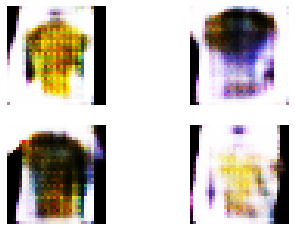

In [15]:
# generate images
latent_points = generate_latent_points(100, 4)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 2)

In [70]:
X[1].shape

(32, 32, 3)